In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

# Setting up the Dataset & Workflow

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
train_dataset = MNIST(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Data mean tensor(0.1307)
Data std tensor(0.3081)


# Transforms ---- Normalization

In [4]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
# Images are 28x28 hence the RandomResizedCrop((28,28)...)
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((28,28), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# Spliting Training & Validation datasets

In [5]:
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = MNIST(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [48000, 12000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [48000, 12000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Veryfing our normalization

In [6]:
# The mean should be close to 0 and the standard deviation close to 1 for each channel
imgs, labels = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0666])
Batch std tensor([0.9994])


# Checking our augmentation

ValueError: num must be an integer with 1 <= num <= 20, not 21

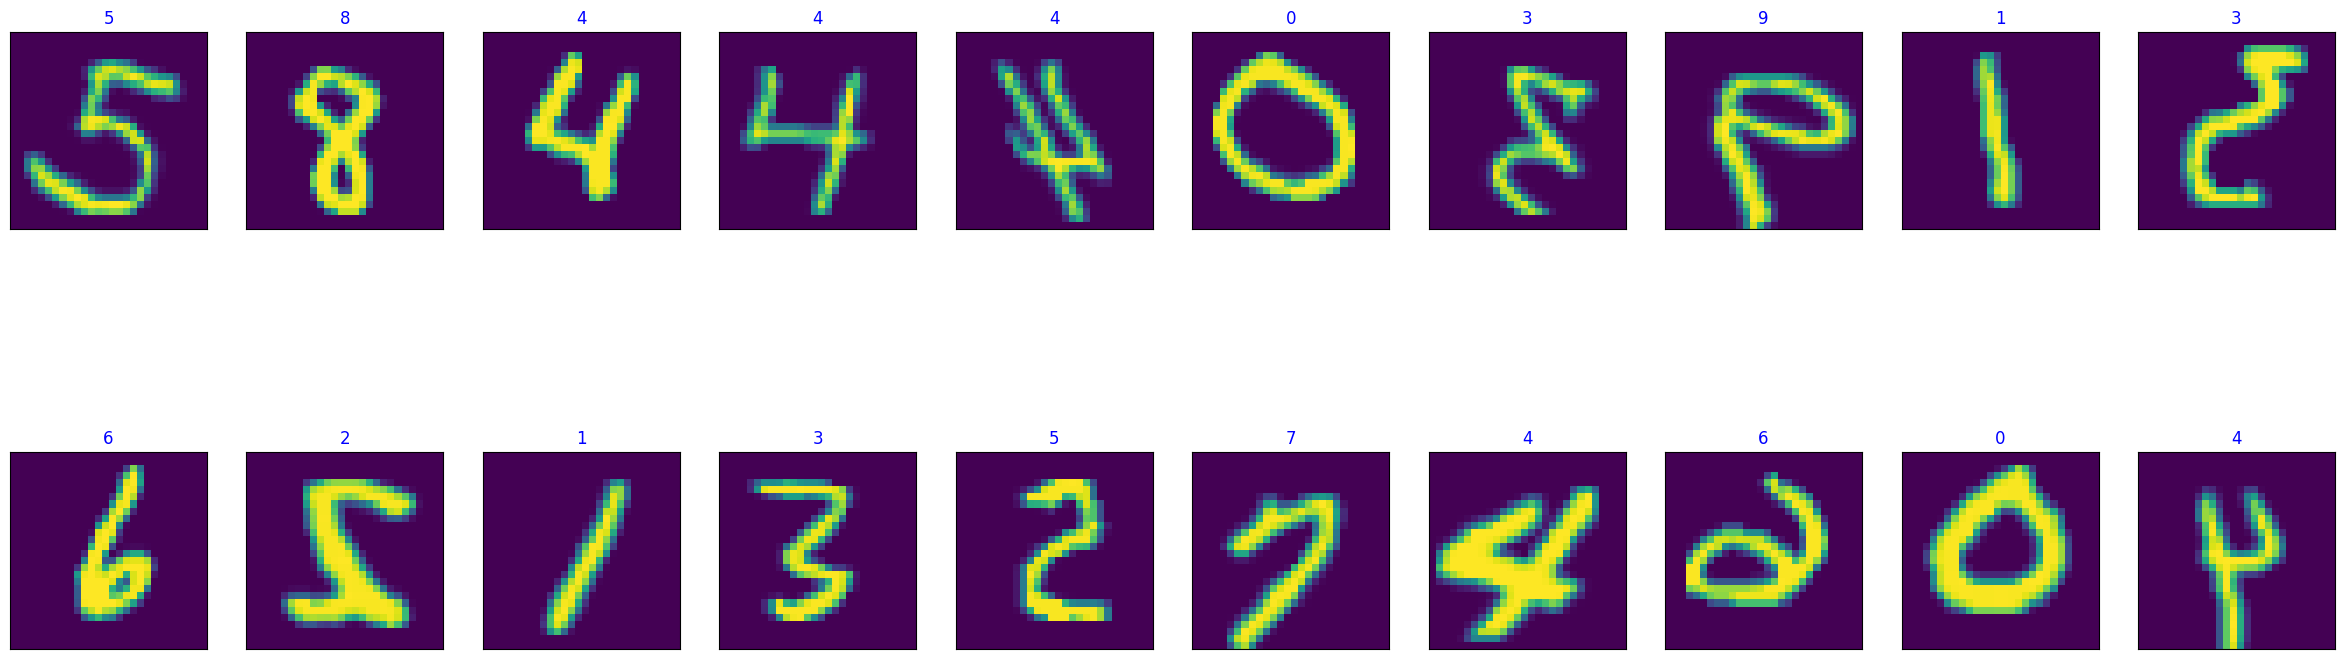

In [7]:
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(imgs[i]))
    ax.set_title(labels[i].item(),color='blue')

# Making a Neural-Network
## For this case we will be using a CNN

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.conv2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1=nn.Linear(7*7*32, 512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256, 10)
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1, 7*7*32)
        x=self.dropout(x)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)
        return x
    

In [9]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Adam optimizer and CrossEntropyLoss
## If we did compute softmax at output we can use NLLLoss

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [11]:
def train_model(model, num_epochs=117):
    train_loss=0.0
    val_loss=0.0
    val_loss_min = np.Inf
    train_correct=0
    val_correct=0

    # For plotting purposes
    loss_keeper={'train':[],'val':[]}
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for imgs, labels in train_loader:
            model.train()
            # Step 1: Move input data to device
            imgs, labels = imgs.to(device), labels.to(device)
            # Step 2: Run the model on the input data
            output = model(imgs)
            output = output.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            # Step 3: Calculate the loss
            loss = loss_fn(output, labels)
            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()
            # Step 5: Update the parameters
            optimizer.step()

            #Tracking Loss and Accuracy
            train_loss+=loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            train_correct+=pred.eq(labels.view_as(pred)).sum().item()

    # Validation loop
        for imgs, labels in val_loader:
            model.eval()
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            output = output.squeeze(dim=1)
            loss = loss_fn(output, labels)
            val_loss+=loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct+=pred.eq(labels.view_as(pred)).sum().item()


        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)

        loss_keeper['train'].append(train_loss)
        loss_keeper['val'].append(val_loss)
        
        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {val_loss}")
        if val_loss<=val_loss_min:
            print(f"Validation loss decreased from : {val_loss_min} ----> {val_loss} ----> Saving Model.......")
            model_name=type(model).__name__
            torch.save(model.state_dict(), model_name+'_model.pth')
            val_loss_min=val_loss
    return(loss_keeper)


In [12]:
m_loss = train_model(model)

  0%|          | 0/117 [00:00<?, ?it/s]


Epoch : 1	Training Loss : 0.9591874062220256	Validation Loss : 0.4621896211137163
Validation loss decreased from : inf ----> 0.4621896211137163 ----> Saving Model.......

Epoch : 2	Training Loss : 0.7152869838553535	Validation Loss : 0.4413587534087661
Validation loss decreased from : 0.4621896211137163 ----> 0.4413587534087661 ----> Saving Model.......

Epoch : 3	Training Loss : 0.6697271236944404	Validation Loss : 0.5148389752490911

Epoch : 4	Training Loss : 0.6450927732968775	Validation Loss : 0.39890973979676825
Validation loss decreased from : 0.4413587534087661 ----> 0.39890973979676825 ----> Saving Model.......

Epoch : 5	Training Loss : 0.6395442654764876	Validation Loss : 0.4826977835494623

Epoch : 6	Training Loss : 0.6255541519774533	Validation Loss : 0.3682155907010338
Validation loss decreased from : 0.39890973979676825 ----> 0.3682155907010338 ----> Saving Model.......

Epoch : 7	Training Loss : 0.6098794006709134	Validation Loss : 0.3499090682634387
Validation loss dec

In [13]:
model.load_state_dict(torch.load('CNN_model.pth'))

C:\Users\top\AppData\Local\Temp\ipykernel_29772\364362160.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CNN_model.pth'))


<All keys matched successfully>

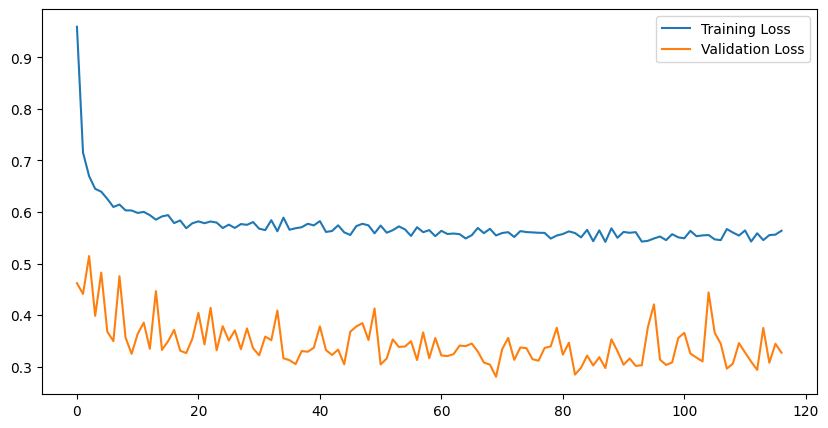

In [15]:
fig, ax=plt.subplots(figsize=(10,5))
ax.plot(m_loss['train'], label="Training Loss")
ax.plot(m_loss['val'], label="Validation Loss")
ax.legend()
plt.show()

# Testing our model

In [39]:
def test_model(model):
    test_loss = 0
    for imgs, labels in val_loader:
            model.eval()
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            output = output.squeeze(dim=1)
            loss = loss_fn(output, labels)
            test_loss+=loss.item()
    
            test_loss = test_loss/len(test_loader)
            print(f"Test Loss: {test_loss}")

    imgs,labels=imgs.to(device),labels.to(device)
    output = model(imgs)
    _, preds = torch.max(output, 1)
    imgs = imgs.cpu().numpy()
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(imgs[idx]))
        ax.set_title("{} for ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

Test Loss: 0.0030182696218732036
Test Loss: 0.003263808625704431
Test Loss: 0.0033760928068705042
Test Loss: 0.0033536002139931335
Test Loss: 0.0026868459734492732
Test Loss: 0.003730050216185359
Test Loss: 0.0031340081542110053
Test Loss: 0.003889602522117397
Test Loss: 0.00440538397444027
Test Loss: 0.003441810289894571
Test Loss: 0.003953924280680119
Test Loss: 0.0038834130022379534
Test Loss: 0.004053566545440995
Test Loss: 0.004989996787493166
Test Loss: 0.0015805870135698734
Test Loss: 0.00449511548366234
Test Loss: 0.004904776452021016
Test Loss: 0.003169742372946853
Test Loss: 0.0027376682716497
Test Loss: 0.0021689232028962793
Test Loss: 0.004027108597651616
Test Loss: 0.0030339476585375044
Test Loss: 0.005057921285267101
Test Loss: 0.003501816518634123
Test Loss: 0.0026721175200769363
Test Loss: 0.0031317762504738454
Test Loss: 0.0027448529205879603
Test Loss: 0.004284535020466797
Test Loss: 0.003474814280300152
Test Loss: 0.002578258106784338
Test Loss: 0.0037884983783743596

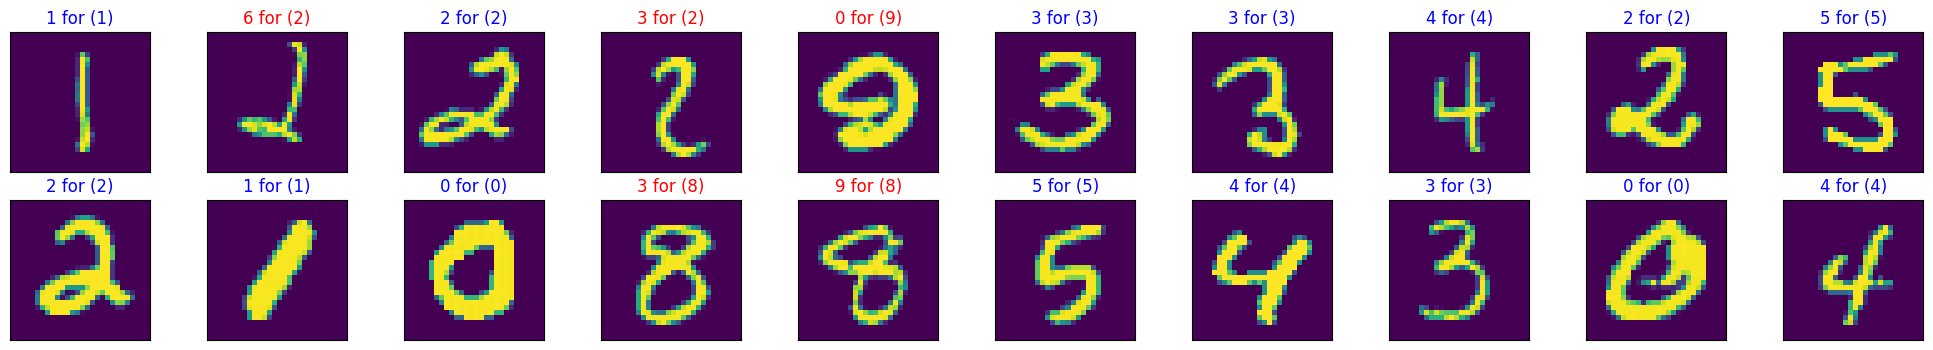

In [40]:
test_model(model)